In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

 Paths set up successfully.
loading annotations into memory...
Done (t=22.80s)
creating index...
index created!
Total COCO training images: 118287
Initial sample size: 20000
 Verifying existence of image files...


Filtering images: 100%|██████████| 20000/20000 [01:04<00:00, 308.86it/s]



Removed 0 image IDs that were missing .jpg files.
Final sample size for processing: 20000

 Displaying 20 Original vs. Processed images...


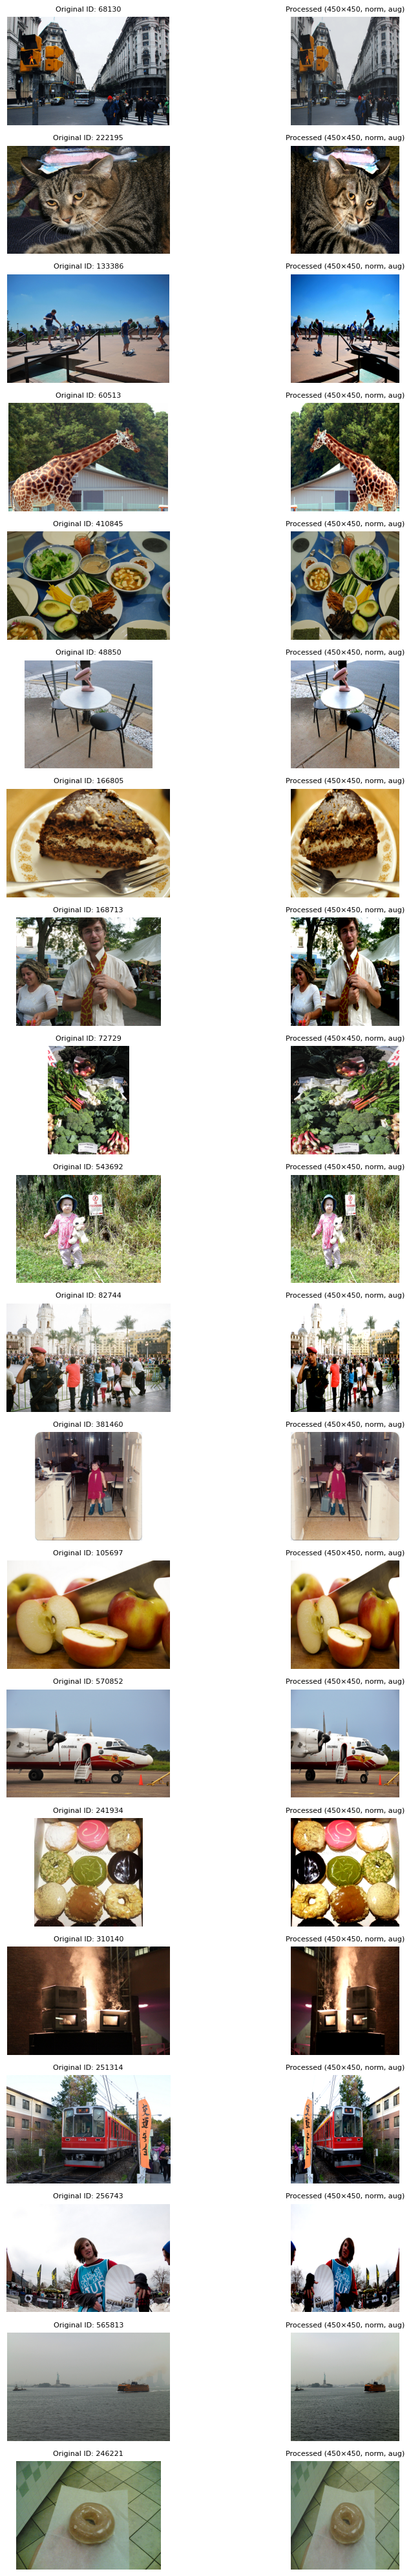


 Preprocessing & visualization complete (20 images).


In [1]:
from pycocotools.coco import COCO
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageEnhance
from tqdm import tqdm
import os
import random


# =======================================================
# 1. PATH SETUP
# =======================================================
data_base_dir = '/kaggle/input/coco-2017-dataset/coco2017'
annFile = os.path.join(data_base_dir, 'annotations/instances_train2017.json')
imgDir = os.path.join(data_base_dir, 'train2017')
saveMaskDir = '/kaggle/working/masks'

os.makedirs(saveMaskDir, exist_ok=True)
print(" Paths set up successfully.")

# =======================================================
# 2. COCO INITIALIZATION
# =======================================================
try:
    coco = COCO(annFile)
except Exception as e:
    print(f" Error loading COCO file. Check if {annFile} is correct.")
    print(e)
    exit()

imgIds = coco.getImgIds()
print("Total COCO training images:", len(imgIds))

# Select 20,000 random image IDs
random.seed(42)
all_sample_ids = random.sample(imgIds, 20000)
print("Initial sample size:", len(all_sample_ids))

# =======================================================
# 3. FILTER OUT MISSING FILES
# =======================================================
filtered_sample_ids = []
missing_count = 0

print(" Verifying existence of image files...")
for img_id in tqdm(all_sample_ids, desc='Filtering images'):
    img_info = coco.loadImgs(img_id)[0]
    img_path = os.path.join(imgDir, img_info['file_name'])
    if os.path.exists(img_path):
        filtered_sample_ids.append(img_id)
    else:
        missing_count += 1

sample_ids = filtered_sample_ids
print(f"\nRemoved {missing_count} image IDs that were missing .jpg files.")
print("Final sample size for processing:", len(sample_ids))

# =======================================================
# 4. IMAGE PREPROCESSING PIPELINE
# =======================================================
def preprocess_image(img_path, resize=(450, 450)):
    """Resize, normalize, and augment the image."""
    img = Image.open(img_path).convert('RGB')

    # --- Resize ---
    img = img.resize(resize)

    # --- Random Horizontal Flip (augmentation) ---
    if random.random() < 0.5:
        img = img.transpose(Image.FLIP_LEFT_RIGHT)

    # --- Random Contrast (augmentation) ---
    enhancer = ImageEnhance.Contrast(img)
    img = enhancer.enhance(random.uniform(0.8, 1.5))  # adjust contrast randomly

    # --- Normalize ---
    img_np = np.array(img).astype(np.float32) / 255.0

    return img_np

# =======================================================
# 5. VISUALIZATION (20 images)
# =======================================================
N_SHOW = 20
fig, axs = plt.subplots(N_SHOW, 2, figsize=(10, N_SHOW * 2))

print(f"\n Displaying {N_SHOW} Original vs. Processed images...")

for i, img_id in enumerate(sample_ids[:N_SHOW]):
    img_info = coco.loadImgs(img_id)[0]
    img_path = os.path.join(imgDir, img_info['file_name'])

    # --- Original ---
    original = Image.open(img_path).convert('RGB')

    # --- Processed ---
    processed = preprocess_image(img_path)

    # Convert processed image back to displayable format (0–1 → 0–255)
    processed_disp = (processed * 255).astype(np.uint8)

    # Plot Original
    axs[i, 0].imshow(original)
    axs[i, 0].axis('off')
    axs[i, 0].set_title(f'Original ID: {img_id}', fontsize=8)

    # Plot Processed
    axs[i, 1].imshow(processed_disp)
    axs[i, 1].axis('off')
    axs[i, 1].set_title('Processed (450×450, norm, aug)', fontsize=8)

plt.tight_layout()
plt.show()

print("\n Preprocessing & visualization complete (20 images).")